In [18]:
import pandas as pd
import numpy as np
import io
import string

from sklearn.preprocessing import MinMaxScaler
import matplotlib as mpl
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from transformers import *
from transformers import BertTokenizer, TFBertModel, BertConfig

In [53]:
# pip install transformers

In [19]:
# Import train, val data from Kaggle dataset: https://www.kaggle.com/praveengovi/emotions-dataset-for-nlp

train = pd.read_csv('train.txt', sep=";", header=None)
val = pd.read_csv('val.txt', sep=";", header=None)
test = pd.read_csv('test.txt', sep=";", header=None)

In [32]:
# Read in tweets_final from Jae's github

tweets = pd.read_csv('tweets_final.txt', sep=",")

In [33]:
tweets.head(2)

,Unnamed: 0,Unnamed: 0.1,id_str,term,created_at,inserted_at,favorite_count,retweet_count,truncated,source,text,is_quote_status,quoted_status_id_str,quoted_status_user_id_str,retweeted_status_id_str,retweeted_status_user_id_str,in_reply_to_status_id_str,in_reply_to_user_id_str,user_followers_count,user_friends_count,user_listed_count,user_id_str,sentiment_compound,sentiment_pos,sentiment_neg,sentiment_neu,created_date,language
0,0,0,1316276527810609152,#Outbreak,2020-10-14 07:15:54,2020-10-22 10:10:03,0,3,0,"<a href=""http://twitter.com/download/android"" ...",RT @GlobalVectorHub: Disease #outbreak news @W...,0,NaN,NaN,1.316126e+18,8.045946e+17,NaN,NaN,8246,9026,354,586521942,0.0,0.0,0.0,1.0,2020-10-14,en
1,1,1,1316277131979231232,#Social,2020-10-14 07:18:18,2020-10-22 10:06:35,0,0,0,"<a href=""https://www.intellitravel.ovh"" rel=""n...",#Photograph of the week: #Social #Distancing i...,0,NaN,NaN,NaN,NaN,NaN,NaN,7120,7746,1096,776383024019767296,0.0,0.0,0.0,1.0,2020-10-14,en


In [37]:
tweets = tweets.text

In [ ]:
len(tweets)

146576

In [ ]:
# Same preprocessing from Jason's Rivanna file

def clean_tweet(series):
    
    """
    series = pandas series of uncleaned tweet data 
    
    This function will convert a tweet string using vectorized string functions and:
    
    1) Remove URLS
    2) Strip Line Breaks
    3) Remove punctuation
    4) Remove numbers
    5) Make lowercase
    
    """
    # Remove URLS
    text = series.str.replace('(?:\@|https?\://)\S+', '', regex=True)
    
    # Strip line breaks 
    text = text.str.replace('\n', ' ')
    
    # Remove punctuation 
    punct = string.punctuation
    
    for x in punct:
        text = text.str.replace(x, '')
        
    # Remove numbers
    text = text.str.replace('\d+', '')
    
    # Make lowercase 
    text = text.str.lower()
    
    return text 

In [ ]:
tweets = clean_tweet(tweets)

In [20]:
# Training data

train.columns = ['Sentence', 'Emotion']
train.head()

,Sentence,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [21]:
train.shape

(16000, 2)

In [ ]:
train.Emotion.value_counts()

joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: Emotion, dtype: int64

In [27]:
# Set up Bert Tokenizer

bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [ ]:
# Create Bert model... also definitely helpful to swith to GPU runtime for the future training step

num_classes = len(train.Emotion.unique())
bert_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=num_classes)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertForSequenceClassification: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['dropout_37', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
bert_model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  109482240 
_________________________________________________________________
dropout_37 (Dropout)         multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  4614      
Total params: 109,486,854
Trainable params: 109,486,854
Non-trainable params: 0
_________________________________________________________________


In [22]:
# Put into format the Bert model can work with

def convert(df):

  df.columns = ['Sentence', 'Emotion']
  df['label'] = df['Emotion'].map({'joy':0, 'sadness':1, 'anger':2, 'fear':3, 'love':4, 'surprise':5})
  
  return df

In [23]:
train = convert(train)
val = convert(val)
test = convert(test)

In [24]:
train.head()

,Sentence,Emotion,label
0,i didnt feel humiliated,sadness,1
1,i can go from feeling so hopeless to so damned...,sadness,1
2,im grabbing a minute to post i feel greedy wrong,anger,2
3,i am ever feeling nostalgic about the fireplac...,love,4
4,i am feeling grouchy,anger,2


In [25]:
# Generate necessary inputs for Bert model from the data 

def preprocess(df):

  if len(df) / df.size == 1.0:
    sentences = df
    labels = []
  else:
    sentences = df['Sentence']
    labels = df['label']

  input_ids=[]
  attention_masks=[]

  for sent in sentences:
      bert_inp=bert_tokenizer.encode_plus(sent, add_special_tokens = True, max_length = 64, pad_to_max_length = True, return_attention_mask = True)
      input_ids.append(bert_inp['input_ids'])
      attention_masks.append(bert_inp['attention_mask'])

  input_ids = np.asarray(input_ids)
  attention_masks = np.array(attention_masks)
  labels = np.array(labels)

  return input_ids, attention_masks, labels

In [28]:
input_ids, attention_masks, labels = preprocess(train)
input_ids_v, attention_masks_v, labels_v = preprocess(val)
input_ids_t, attention_masks_t, labels_t = preprocess(test)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2179: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
# Set up optimizer, loss, and callbacks

log_dir='tensorboard_data/tb_bert'
model_save_path='./models/bert_model.h5'

callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath=model_save_path,save_weights_only=True,monitor='val_loss',mode='min',save_best_only=True),keras.callbacks.TensorBoard(log_dir=log_dir)]

print('\nBert Model', bert_model.summary())

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5,epsilon=1e-08)

bert_model.compile(loss=loss,optimizer=optimizer,metrics=[metric])

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  109482240 
_________________________________________________________________
dropout_37 (Dropout)         multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  4614      
Total params: 109,486,854
Trainable params: 109,486,854
Non-trainable params: 0
_________________________________________________________________

Bert Model None


In [ ]:
# Train model on train data with validation data also

history = bert_model.fit([input_ids, attention_masks], labels, batch_size=8, epochs=5, validation_data=([input_ids_v, attention_masks_v], labels_v), callbacks=callbacks)

Epoch 1/5
   1/2000 [..............................] - ETA: 0s - loss: 1.8240 - accuracy: 0.1250WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
2000/2000 [==============================] - 259s 129ms/step - loss: 0.4278 - accuracy: 0.8522 - val_loss: 0.2065 - val_accuracy: 0.9260
Epoch 2/5
2000/2000 [==============================] - 263s 131ms/step - loss: 0.1368 - accuracy: 0.9411 - val_loss: 0.1365 - val_accuracy: 0.9340
Epoch 3/5
2000/2000 [==============================] - 262s 131ms/step - loss: 0.1016 - accuracy: 0.9509 - val_loss: 0.1553 - val_accuracy: 0.9325
Epoch 4/5
2000/2000 [==============================] - 263s 132ms/step - loss: 0.0935 - accuracy: 0.9542 - val_loss: 0.1400 - val_accuracy: 0.9365
Epoch 5/5
2000/2000 [===========================

In [ ]:
# Create predictions with test data

preds = bert_model.predict([input_ids_t, attention_masks_t])

In [ ]:
np.shape(preds)

(1, 2000, 6)

In [ ]:
# Find most probable prediction (in the future could be good to delete uncertain ones)

np.argmax(np.squeeze(preds), axis=1)[0:20]

array([1, 1, 1, 0, 1, 3, 2, 0, 0, 2, 2, 1, 3, 0, 4, 1, 0, 1, 2, 0])

In [ ]:
# Compare with test labels

test.label[0:20]

0     1
1     1
2     1
3     0
4     1
5     3
6     2
7     0
8     0
9     2
10    3
11    1
12    3
13    0
14    4
15    1
16    0
17    1
18    2
19    0
Name: label, dtype: int64

In [ ]:
# Preprocess tweets exactly the same as we did for train, val and test data

input_ids, attention_masks, labels = preprocess(tweets)

In [ ]:
# Predict on tweets

tweet_preds = bert_model.predict([input_ids, attention_masks])

In [ ]:
# See highest probability prediction for tweets

max_pred = np.argmax(np.squeeze(tweet_preds), axis=1)

In [ ]:
# Combine tweet with sentiment

tweet_sent = pd.DataFrame(data = {'text':tweets, 'label':max_pred})

In [ ]:
tweet_sent.head(10)

,text,label
0,rt disease outbreak news oropouche virus dis...,3
1,photograph of the week social distancing in th...,2
2,new coronavirus cases are up by at least in ...,3
3,photograph of the week social distancing withi...,0
4,total confirmed total recovered total dea...,0
5,several regions sound alarm as us reports most...,3
6,hockey on hold waiting time again corona ou...,0
7,a recent study shows that most diners want soc...,2
8,rt disease outbreak news oropouche virus dis...,3
9,nations of the african outbreak response allia...,0


In [ ]:
tweet_sent.to_csv('tweet_sent.csv')

In [ ]:
tweet_sent = pd.read_csv('tweet_sent.csv', lineterminator='\n')

In [ ]:
# Add dates back to the database (should've kept this earlier, but whatever)

tweet_sent = pd.concat([tweet_sent, tweets.created_at], axis = 1)
tweet_sent['date'] = pd.to_datetime(tweet_sent['created_at']).dt.date
tweet_sent = tweet_sent.loc[:, ['text', 'label', 'date']]

tweet_sent.to_csv('tweet_senti.csv')

In [42]:
tweet_sent = pd.read_csv('tweet_senti.csv', lineterminator='\n')

In [43]:
tweet_sent.head()

,Unnamed: 0,text,label,date
0,0,rt disease outbreak news oropouche virus dis...,3.0,2020-10-14
1,1,photograph of the week social distancing in th...,2.0,2020-10-14
2,2,new coronavirus cases are up by at least in ...,3.0,2020-10-14
3,3,photograph of the week social distancing withi...,0.0,2020-10-14
4,4,total confirmed total recovered total dea...,0.0,2020-10-14


In [44]:
tweet_sent = tweet_sent.loc[:, ['date', 'text', 'label']]

In [45]:
pd.set_option('display.max_colwidth', None)

In [52]:
# See random tweets that were labled as Joy

joy = tweet_sent[tweet_sent.label == 0]
joy.sample(4)

,date,text,label
44064,2020-10-27,rt cases are up because testing more but death rate from covid is down this is very goodnews you wont hear it on t…,0.0
61606,2020-10-28,appreciating today’s thought provoking agefriendly regional roundtable discussion about creating equitable agefriendly communities as we deal with twin pandemics covid amp systemicracism,0.0
9161,2020-10-21,conferencia de prensa covid de octubre de graciasporcuidarnos,0.0
93461,2020-11-01,rt australia covid deathscapita of us swift and stringent measures combined with community compliance have been cred…,0.0


In [ ]:
sadness = tweet_sent[tweet_sent.label == 1]
sadness.sample(4)

,date,text,label
128063,2020-11-08,rt devastating— members of a south dakota family died from covid janice lost her sister brother in law cousin and her…,1
130101,2020-11-09,while this infantile monster is wanting to sue the very basis of democracy i wonder if the families of all those who died of corona can start a class action suit against him for wrongful death,1
37367,2020-10-27,this x if “don’t order a test you can’t follow up on” is a maxim of testing then it can’t be understated that support during quarantine is how you follow up on a covid test especially for disadvantaged communities disproportionately impacted by this virus,1
566,2020-10-17,covid coronavirus outbreak update total cases total deaths more details coronavirus covid outbreak,1


In [ ]:
anger = tweet_sent[tweet_sent.label == 2]
anger.sample(4)

,date,text,label
35998,2020-10-27,rt “speed trumps perfection” michael ryan who chief executive director tasked with containing the covid outbreak inter…,2
34977,2020-10-27,americas frontline doctors censored again on covid treatments masks and negative effects of lockdowns link to their second summit in dc reopen,2
50947,2020-10-28,rt the mask you call avoids traveling to the core north in mortal fear of his fellow fulani bandit terrorists…,2
109893,2020-11-03,covid covid mexico,2


In [ ]:
fear = tweet_sent[tweet_sent.label == 3]
fear.sample(4)

,date,text,label
4565,2020-10-21,rt mask safety coronavirusoutbreak,3
109550,2020-11-03,medicine nov by coronavirus covid pandemic argentina update,3
89297,2020-11-01,prevent flu soap away germs from washyourhands,3
11207,2020-10-23,coronavirus contagi e decessi,3


In [ ]:
love = tweet_sent[tweet_sent.label == 4]
love.sample(4)

,date,text,label
129451,2020-11-09,make happiness a priority and be gentle with your self in the process have a good day and goodmorningeveryone stayhome staysafe washyourhands goodday stayblessed,4
94871,2020-11-02,extra virgin olive oil soap with vitamin e very gentle san francisco extravirginoliveoil oliveoil olive olivesoap naturalsoap gentleskincare bathandbeauty washyourhands bodycare handmadesoap,4
61435,2020-10-28,precisely covid was the first real issue that he couldn’t tweet gaslight or distract away the pandemic exposed him for what he’s always been a narcissistic amoral ignoramus,4
125032,2020-11-08,black labradorretriever puppy facemask with pattern art printed on the front washable in hot water and reusable double layered mask made in usa,4


In [ ]:
surprise = tweet_sent[tweet_sent.label == 5]
surprise.sample(4)

,date,text,label
136854,2020-11-10,rt very interesting paper in on identifying covid transmission via mobile phone data from million people stud…,5
143898,2020-11-10,rt we launched tonight raising almost £ for amazing organisations future proofing our youth from the impact of c…,5
14295,2020-10-25,rt i created few seconds horror chemnitz chemnitz corona coronavirusde covid sachsen,5
1472,2020-10-19,the american people on both sides needed to know the truth months ago i would not be surprised if the whole coronavirus began as a political act of murder to get to trump supporters interestingly it appears the worse of the deaths are the democratic voters,5


In [ ]:
counts = tweet_sent.groupby(['date', 'label']).count()

In [ ]:
# Get % of each emotion tweets by day

emo_pcts = counts.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))

In [ ]:
emo_pcts

text
date       label           
2020-10-14 0      27.480916
           1       3.053435
           2      32.824427
           3      36.641221
2020-10-15 0      21.461187
...                     ...
2020-11-10 1       3.319428
           2      49.400905
           3       8.209816
           4       0.213011
           5       0.532529

[155 rows x 1 columns]

In [ ]:
# Reshape into a graphable form

emos = emo_pcts.unstack().fillna(0)
emos.columns = emos.columns.droplevel()
emos.columns = ['joy', 'sadness', 'anger', 'fear', 'love', 'surprise']
emos.head()

,joy,sadness,anger,fear,love,surprise
date,,,,,,
2020-10-14,27.480916,3.053435,32.824427,36.641221,0.0,0.000000
2020-10-15,21.461187,4.566210,39.269406,34.246575,0.0,0.456621
2020-10-16,22.839506,8.024691,27.160494,41.358025,0.0,0.617284
2020-10-17,24.015748,3.937008,48.425197,23.622047,0.0,0.000000
2020-10-18,28.853755,5.138340,35.573123,30.434783,0.0,0.000000


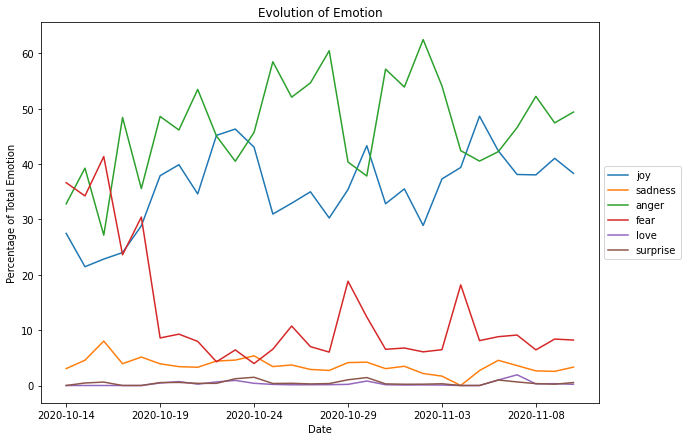

In [ ]:
# Would be cool to see how this changes around vaccine news

emos.plot(title = 'Evolution of Emotion', xlabel = 'Date', ylabel = 'Percentage of Total Emotion', figsize = (10, 7)).legend(loc='center left', bbox_to_anchor=(1.0, 0.5))